In [45]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import pandas as pd
import statsmodels as st
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch.utils.data as data_utils

In [46]:
data = pd.read_csv('./final.csv', index_col=0)
data['crime'] = data['Rate per 100,000 population']
data = data.drop(columns=['Rate per 100,000 population'])

def normalize(col):
    col = ''.join(col.split())
    col = ''.join(e for e in col if e.isalnum())
    out: str = col.replace(',','_').lower()
    if out[0].isdigit():
        out = '_' + out
    return out

data.rename(columns=normalize, inplace=True)
data.describe()

,year,egm,medianhouseprice,offencecount,traveltimetogpominutes,areakm2,ariamin,ariamax,ariaavg,commercialkm2,...,presentationstoemergencydepartments201213,traveltimetonearestpublichospitalwithemergencydepartment,presentationstoemergencydepartmentsduetoinjury,category45emergencydepartmentpresentations,numberofdwellings,population,locationx,locationy,absremotenesscategory,crime
count,392.000000,3.920000e+02,3.920000e+02,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,...,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,2017.000000,4.479159e+07,6.974263e+05,8807.719388,87.531777,2427.304028,0.638564,0.915607,0.765623,0.015513,...,0.270842,25.794808,0.248449,0.567065,40813.517857,101211.071429,-0.204235,26.559082,0.589286,8604.032054
std,2.002556,3.648647e+07,4.668703e+05,6836.585681,89.737139,4388.218811,0.926171,1.249630,1.076033,0.024319,...,0.117438,23.200132,0.039385,0.076904,24837.496782,67489.684405,103.654912,82.711984,0.702344,3506.884396
min,2014.000000,1.892293e+06,1.587500e+05,387.000000,4.897709,20.822930,0.000000,0.000000,0.000000,0.000052,...,0.050232,3.930699,0.140255,0.399250,4874.000000,9873.000000,-310.285714,-81.599301,0.000000,3076.800763
25%,2015.000000,1.182050e+07,3.520722e+05,3061.750000,20.246923,79.778887,0.000000,0.000000,0.000000,0.000368,...,0.180694,8.626692,0.218529,0.513066,18526.750000,41610.000000,-23.545417,-15.651445,0.000000,6471.102274
50%,2017.000000,3.108051e+07,5.853513e+05,8011.000000,52.602954,667.579973,0.064858,0.193099,0.117857,0.002763,...,0.252941,16.079150,0.256317,0.567085,40520.000000,94681.500000,5.389039,1.222753,0.000000,8194.577278
75%,2019.000000,6.885112e+07,9.037315e+05,12515.500000,131.271874,3206.892301,1.088661,1.512202,1.384535,0.025111,...,0.375373,34.781852,0.278871,0.616169,59403.000000,151932.500000,27.746864,40.975396,1.000000,10228.073289
max,2020.000000,1.430457e+08,2.841161e+06,37886.000000,384.960766,23359.313312,3.272194,4.383425,3.737190,0.127473,...,0.553260,96.843507,0.322547,0.725373,107828.000000,298909.000000,274.239407,343.714443,2.000000,25932.263717


In [47]:
actual = data[data['year'].isin(list(range(2015, 2021)))]
actual = actual.copy()

# insert last year
for i, row in actual.iterrows():
    last = data[(data['year'] == row['year']-1) & (data['lga'] == row['lga'])].copy()
    distance = np.sqrt(row['locationx'] ** 2 + row['locationy'] ** 2)
    actual.loc[i, 'distance'] = distance
    actual.loc[i, 'last_crime'] = last['crime'].values[0]
    actual.loc[i, 'last_house'] = last['medianhouseprice'].values[0]
    actual.loc[i, 'last_egm'] = last['egm'].values[0]

actual = actual.reset_index(drop=True)
actual = actual.drop(columns=['offencecount'], axis=1)
cr = actual.pop('crime')
actual.insert(actual.shape[1], "crime", cr)
actual

,lga,year,egm,medianhouseprice,traveltimetogpominutes,areakm2,ariamin,ariamax,ariaavg,commercialkm2,...,numberofdwellings,population,locationx,locationy,absremotenesscategory,distance,last_crime,last_house,last_egm,crime
0,whittlesea,2015,1.091612e+08,3.864022e+05,34.862554,590.075860,0.007974,0.056596,0.022594,0.005186,...,53907.0,166996.0,16.070609,18.525154,0,24.524392,7233.141209,3.567570e+05,1.035006e+08,6975.468257
1,northerngrampians,2015,1.003788e+07,1.590000e+05,179.410340,6720.196354,2.135649,2.837918,2.452597,0.000128,...,7094.0,13042.0,-179.798887,102.227446,2,206.828650,7947.694659,1.587500e+05,1.035065e+07,9876.331158
2,greatergeelong,2015,1.130210e+08,4.230712e+05,61.820207,1389.430557,0.152898,0.224843,0.182097,0.002401,...,107828.0,249716.0,-49.407904,-36.376751,0,61.354779,8127.107630,4.084374e+05,1.116281e+08,8950.482127
3,colacotway,2015,1.026330e+07,3.823333e+05,137.416278,3232.099823,1.273625,1.806754,1.531375,0.000364,...,11821.0,21429.0,-114.485347,-75.055345,1,136.894848,7259.476598,3.684167e+05,1.007489e+07,7899.199246
4,moorabool,2015,1.057564e+07,3.560000e+05,58.368445,2142.863230,0.331739,0.880712,0.598316,0.000394,...,18640.0,47165.0,-63.629211,23.520312,1,67.837170,6183.609090,3.395000e+05,1.030988e+07,6857.124858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,maribyrnong,2020,4.224321e+07,8.882343e+05,11.629266,31.347530,0.000000,0.000000,0.000000,0.068430,...,33248.0,81443.0,-7.275384,1.522394,0,7.432960,9949.698189,8.490697e+05,5.725792e+07,10239.549084
332,stonnington,2020,1.411828e+07,2.841161e+06,9.937739,23.986985,0.000000,0.000000,0.000000,0.066525,...,46028.0,96855.0,4.834074,-4.292877,0,6.465065,10326.889279,2.535312e+06,1.986235e+07,10291.270757
333,gleneira,2020,5.402530e+07,1.516358e+06,15.409791,41.586761,0.000000,0.000000,0.000000,0.032422,...,62435.0,150761.0,6.103827,-8.569276,0,10.520894,4799.397152,1.430137e+06,7.424468e+07,5086.773226
334,bayside,2020,1.022713e+07,1.744736e+06,20.118347,35.882194,0.000000,0.000000,0.000000,0.023797,...,38495.0,97337.0,5.883758,-14.204648,0,15.375000,4849.326535,1.572118e+06,1.380787e+07,5319.088156


In [48]:
# one hot encode
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

encoded = actual.copy()
# encoded = encoded[[
#     'lga', 'last_crime',
#       'distance', 'last_egm', 'egm', 'last_house', 
#       'medianhouseprice', 
#       'crime']]

encoded = encoded[[
    'lga', 
    'last_crime',
      'distance', 
      'last_egm', 
      'last_house',
      'crime']]

new_ = encoded.select_dtypes(include=[np.number])


# standardize all
encoder = OneHotEncoder()
out = encoder.fit_transform(encoded[['lga']])
lga = pd.DataFrame(out.toarray())

new = pd.concat([lga, new_], axis=1)
crime_idx = new.columns.get_loc('crime')
last_idx = new.columns.get_loc('last_crime')

print(crime_idx, last_idx)

print(np.sum(new.isna().sum()))
print(np.mean((new["last_crime"] - new["crime"])**2))

new['crime'] /= 20000

new

60 56
0
888074.5887995105


,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,last_crime,distance,last_egm,last_house,crime
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,7233.141209,24.524392,1.035006e+08,3.567570e+05,0.348773
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7947.694659,206.828650,1.035065e+07,1.587500e+05,0.493817
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8127.107630,61.354779,1.116281e+08,4.084374e+05,0.447524
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7259.476598,136.894848,1.007489e+07,3.684167e+05,0.394960
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6183.609090,67.837170,1.030988e+07,3.395000e+05,0.342856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9949.698189,7.432960,5.725792e+07,8.490697e+05,0.511977
332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10326.889279,6.465065,1.986235e+07,2.535312e+06,0.514564
333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4799.397152,10.520894,7.424468e+07,1.430137e+06,0.254339
334,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4849.326535,15.375000,1.380787e+07,1.572118e+06,0.265954


In [49]:
# ml model


# one hot encode

state = 41
train_data: pd.DataFrame = new.sample(frac=0.7, random_state=state)
test_data = new.drop(train_data.index)

train_y = train_data['crime'].values
train_x = train_data.drop('crime', axis=1).values

test_y = test_data['crime'].values
test_x = test_data.drop('crime', axis=1).values

scaler_x = MinMaxScaler(feature_range=(0,1))
scaler_x.fit(train_x)
# scaler_y.fit(train_y.reshape(-1, 1))

train_x = scaler_x.transform(train_x)
# train_y = scaler_y.transform(train_y.reshape(-1, 1))
train_y = train_y


test_y = test_y
# test_y = scaler_y.transform(test_y.reshape(-1, 1))
test_x = scaler_x.transform(test_x)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

batch_size = 1

train = data_utils.TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test = data_utils.TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

# Create data loaders.
train_dataloader = DataLoader(train, batch_size=batch_size)
test_dataloader = DataLoader(test, batch_size=batch_size)

for X, y in test_dataloader:
    print(X)
    print(y)
    # print(f"Shape of X [N, C, H, W]: {X.shape}")
    # print(f"Shape of y: {y.shape} {y.dtype}")
    break


# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(train_x.shape[1], 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)



(235, 60) (235,)
(101, 60) (101,)
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.1359, 0.1505, 0.0569, 0.0725]])
tensor([0.3429])
Using cpu device


In [50]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch % 10 == 0:
            # loss, current = loss.item(), (batch + 1) * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # print(np.array(X[:, last_idx]))
            # print((np.array(X[:, last_idx]) - np.array(y)))

    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")


In [51]:
import copy
import warnings
warnings.filterwarnings('ignore')

epochs = 1000
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    model.train()
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    

print("Done!")

Avg loss: 0.029429 

Avg loss: 0.027667 

Avg loss: 0.025598 

Avg loss: 0.022952 

Avg loss: 0.019503 

Avg loss: 0.015365 

Avg loss: 0.011178 

Avg loss: 0.007719 

Avg loss: 0.005450 

Avg loss: 0.004224 

Avg loss: 0.003572 

Avg loss: 0.003185 

Avg loss: 0.002932 

Avg loss: 0.002753 

Avg loss: 0.002623 

Avg loss: 0.002528 

Avg loss: 0.002458 

Avg loss: 0.002404 

Avg loss: 0.002362 

Avg loss: 0.002331 

Avg loss: 0.002306 

Avg loss: 0.002289 

Avg loss: 0.002276 

Avg loss: 0.002264 

Avg loss: 0.002257 

Avg loss: 0.002251 

Avg loss: 0.002249 

Avg loss: 0.002244 

Avg loss: 0.002243 

Avg loss: 0.002240 

Avg loss: 0.002238 

Avg loss: 0.002237 

Avg loss: 0.002236 

Avg loss: 0.002234 

Avg loss: 0.002234 

Avg loss: 0.002231 

Avg loss: 0.002231 

Avg loss: 0.002230 

Avg loss: 0.002228 

Avg loss: 0.002227 

Avg loss: 0.002225 

Avg loss: 0.002223 

Avg loss: 0.002222 

Avg loss: 0.002222 

Avg loss: 0.002219 

Avg loss: 0.002219 

Avg loss: 0.002217 

Avg loss: 0.0

Model:  [0.04242707]
Null:  [[0.05296418]]
Linear:  [0.05175687]


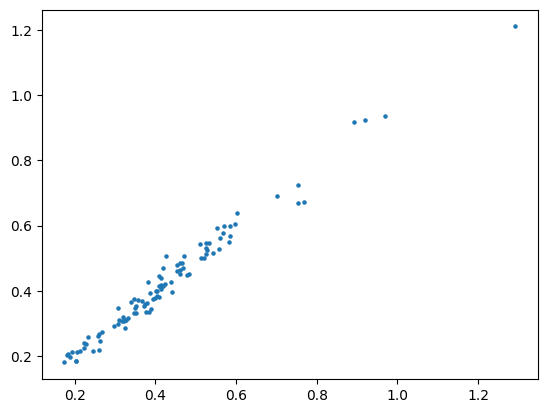

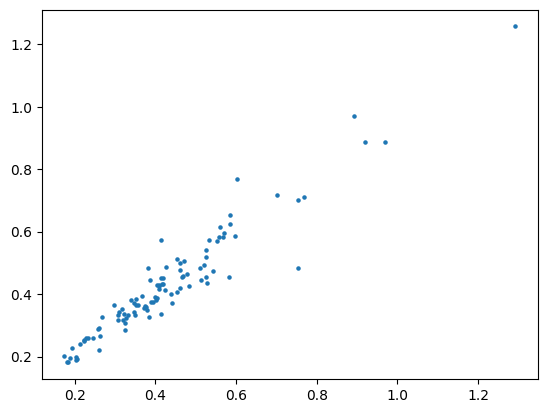

In [53]:
# Linear model
m, b = np.polyfit(train_data["last_crime"], train_data["crime"], deg=1)

model.eval()
predNulls = []
predCrimes = []
actual = []
with torch.no_grad():
    i = 0
    target = 10
    mse = 0
    mseNull = 0
    mseLinear = 0
    for x, y in test_dataloader:
        i += 1

        out = np.hstack((x[:,56:], y.reshape(-1,1)))
        crime = out[:, crime_idx - 56]
        x = x.to(device)
        
        pred = model(x)
        pred = pred.detach().cpu().numpy()

        x = x.detach().cpu().numpy()
        out = np.hstack((x[:,56:], pred.reshape(-1,1)))
        pred = out[:, crime_idx - 56]

        predNull = scaler_x.inverse_transform(x)[:, last_idx].reshape(-1,1)/2e4

        predLinear = b + m * scaler_x.inverse_transform(x)[:, last_idx]


        # print(f'Predicted: "{pred}",\n Actual: "{crime}"')
        # print("Linear", predLinear)

        mse += (pred - crime) ** 2
        mseNull += (predNull - crime)**2
        mseLinear += (predLinear - crime)**2

        predNulls.append(predNull)
        predCrimes.append(pred)
        actual.append(crime)

    print("Model: ", np.sqrt(mse/i))
    print("Null: ", np.sqrt(mseNull/i))
    print("Linear: ", np.sqrt(mseLinear/i))

plt.figure()
plt.scatter(predNulls, predCrimes, s= 5)
plt.show()

plt.figure()
plt.scatter(predNulls, actual, s=5)
plt.show()